In [5]:
import json

wrong = []
with open('./debiased_model_eval_output3/eval_predictions.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        if data['predicted_label'] != data['label']:
            wrong.append(data)

print(f"Total wrong: {len(wrong)}")
dict = {"0,1":0, "0,2":0, "1,0":0, "1,2":0, "2,0":0, "2,1":0}
for i, ex in enumerate(wrong):
    key = f"{ex['label']},{ex['predicted_label']}"
    dict[key] += 1

print("Confusion counts:")
for k, v in dict.items():
    print(f"  {k}: {v}")

# Show first 10
for i, ex in enumerate(wrong):
    count = 0
    if ex['label'] == 2 and ex['predicted_label'] == 1:
        print(f"\n{i+1}. TRUE LABEL: {ex['label']}, PREDICTED: {ex['predicted_label']}")
        print(f"   Premise: {ex['premise']}")
        print(f"   Hypothesis: {ex['hypothesis']}")
        count += 1
        if count >= 20:
            break



Total wrong: 1084
Confusion counts:
  0,1: 236
  0,2: 74
  1,0: 222
  1,2: 232
  2,0: 77
  2,1: 243

2. TRUE LABEL: 2, PREDICTED: 1
   Premise: Families waiting in line at an amusement park for their turn to ride.
   Hypothesis: People are waiting to see a movie.

6. TRUE LABEL: 2, PREDICTED: 1
   Premise: A taxi SUV drives past an urban construction site, as a man walks down the street in the other direction.
   Hypothesis: A man is chasing an SUV that is going in the same direction as him.

8. TRUE LABEL: 2, PREDICTED: 1
   Premise: The two farmers are working on a piece of John Deere equipment.
   Hypothesis: 2 Men are making a pool together

20. TRUE LABEL: 2, PREDICTED: 1
   Premise: A small ice cream stand with two people standing near it.
   Hypothesis: Two people selling ice cream from a car.

24. TRUE LABEL: 2, PREDICTED: 1
   Premise: A lady with bright orange hair walking in a crowd.
   Hypothesis: The street performer is entertaining the tourists.

37. TRUE LABEL: 2, PREDIC

In [36]:
overlap_data = []

with open('./eval_output/eval_predictions.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)

        # Get words from each sentence
        premise_words = set(data['premise'].lower().split())
        hypothesis_words = set(data['hypothesis'].lower().split())

        # Count overlap
        overlap_count = len(premise_words.intersection(hypothesis_words))

        # Store with labels
        overlap_data.append({
            'overlap_count': overlap_count,
            'true_label': data['label'],
            'pred_label': data['predicted_label'],
            'correct': data['label'] == data['predicted_label']
        })

# Now analyze
correct_overlaps = [x['overlap_count'] for x in overlap_data if x['correct']]
incorrect_overlaps = [x['overlap_count'] for x in overlap_data if not x['correct']]

print(f"Average overlap (correct): {sum(correct_overlaps)/len(correct_overlaps):.2f}")
print(f"Average overlap (incorrect): {sum(incorrect_overlaps)/len(incorrect_overlaps):.2f}")


# Look at contradiction→neutral errors specifically
contradict_to_neutral = [x for x in overlap_data
                        if x['true_label']==2 and x['pred_label']==1]

c2n_overlaps = [x['overlap_count'] for x in contradict_to_neutral]
print(f"\nContradiction→Neutral errors:")
print(f"Average overlap: {sum(c2n_overlaps)/len(c2n_overlaps):.2f}")

Average overlap (correct): 3.00
Average overlap (incorrect): 2.94

Contradiction→Neutral errors:
Average overlap: 2.56


In [13]:

baseline_right_debiased_wrong = []

with open('./full_model_eval_output/eval_predictions.jsonl', 'r') as baseline_file:
    with open('./debiased_model_eval_output2/eval_predictions.jsonl', 'r') as debiased_file:
        for baseline_line, debiased_line in zip(baseline_file, debiased_file):

            baseline_data = json.loads(baseline_line)
            debiased_data = json.loads(debiased_line)

            if (baseline_data['label'] == debiased_data['label'] and
                baseline_data['predicted_label'] == baseline_data['label'] and
                debiased_data['predicted_label'] != debiased_data['label']):

                baseline_right_debiased_wrong.append({
                    'premise': baseline_data['premise'],
                    'hypothesis': baseline_data['hypothesis'],
                    'true_label': baseline_data['label'],
                    'baseline_pred': baseline_data['predicted_label'],
                    'debiased_pred': debiased_data['predicted_label']
                })

print(f"Found {len(baseline_right_debiased_wrong)} examples where baseline was right but debiased was wrong\n")

for i, ex in enumerate(baseline_right_debiased_wrong[:5]):
    print(f"\nExample {i+1}:")
    print(f"  Premise: {ex['premise']}")
    print(f"  Hypothesis: {ex['hypothesis']}")
    print(f"  True Label: {ex['true_label']}")
    print(f"  Baseline: {ex['baseline_pred']} ✓")
    print(f"  Debiased: {ex['debiased_pred']} ✗")

Found 227 examples where baseline was right but debiased was wrong


Example 1:
  Premise: A young boy in a field of flowers carrying a ball
  Hypothesis: boy leaving baseball game
  True Label: 1
  Baseline: 1 ✓
  Debiased: 2 ✗

Example 2:
  Premise: Families waiting in line at an amusement park for their turn to ride.
  Hypothesis: People are waiting to see a movie.
  True Label: 2
  Baseline: 2 ✓
  Debiased: 1 ✗

Example 3:
  Premise: A small ice cream stand with two people standing near it.
  Hypothesis: Two people selling ice cream from a car.
  True Label: 2
  Baseline: 2 ✓
  Debiased: 1 ✗

Example 4:
  Premise: A man poses for a photo in front of a Chinese building by jumping.
  Hypothesis: The man has experience in taking photos.
  True Label: 1
  Baseline: 1 ✓
  Debiased: 0 ✗

Example 5:
  Premise: A boy in red slides down an inflatable ride.
  Hypothesis: A boy pierces a knife through an inflatable ride.
  True Label: 2
  Baseline: 2 ✓
  Debiased: 1 ✗


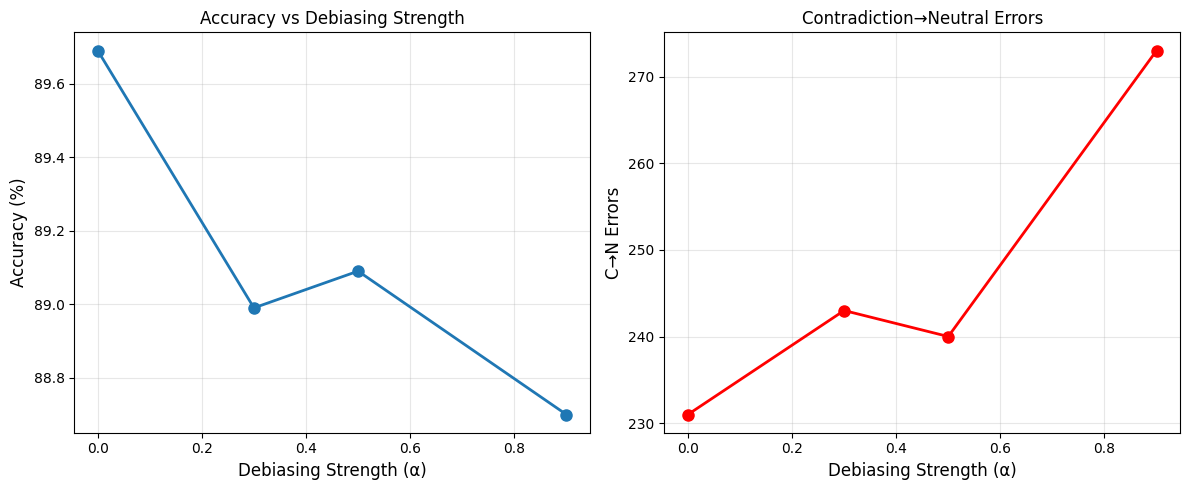

In [18]:
import matplotlib.pyplot as plt

alpha_values = [0.0, 0.3, 0.5, 0.9]
accuracy = [89.69, 88.99, 89.09, 88.70]
cn_errors = [231, 243, 240, 273]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(alpha_values, accuracy, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Debiasing Strength (α)', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy vs Debiasing Strength')
ax1.grid(True, alpha=0.3)

# C→N errors plot
ax2.plot(alpha_values, cn_errors, 'o-', color='red', linewidth=2, markersize=8)
ax2.set_xlabel('Debiasing Strength (α)', fontsize=12)
ax2.set_ylabel('C→N Errors', fontsize=12)
ax2.set_title('Contradiction→Neutral Errors')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('debiasing_results.png', dpi=300, bbox_inches='tight')
plt.show()